1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.

데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.

적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.

3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

## STEP 0. 라이브러리 불러오기
---


In [107]:
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import os
import datetime as dt
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 구드 연결
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## STEP 1. 데이터 로드 및 전처리
---
데이터는 저번에 사용한 Movielens 데이터를 사용합니다!

In [50]:
########### Data Load #############
path = '/content/drive/MyDrive/COLAB_data/recommend_movie/'

train_path = path + 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['user_id', 'movie_id', 'ratings', 'timestamp']
    return data

data = load_data(train_path, None)
data.sort_values(['user_id', 'timestamp'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,user_id,movie_id,ratings,timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 1-1. User Id 기준 데이터 확인 
---

유저의 수와 아이템인 뮤비의 수를 확인해봅니다.

In [4]:
data['user_id'].nunique(), data['movie_id'].nunique()

(6040, 3706)

유저 6040명과 뮤비아이템 3706개가 있는것을 확인했습니다.  

기존 사용했던 데이터의 설명으로 각 사용자는 최소 20개의 평가를 가지고 있다는 것을 알지만 한번 직접 보겠습니다.

In [5]:
########## Id별 평가 수 확인 ###########
UserId_length = data.groupby('user_id').size()

UserId_length

user_id
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
######## 중앙값, 평균값 확인 ##########
UserId_length.median(), UserId_length.mean()

(96.0, 165.5975165562914)

In [7]:
########## 최소, 최대 값 확인 ##########
UserId_length.min(), UserId_length.max()

(20, 2314)

In [8]:
########### 99%의 유저가 별점준 갯수 ###########
UserId_length.quantile(0.999)

1343.181000000005

와우... 보통 165개의 영화 별점을 부여했네요!  
하지만 2314개의 별점을 부여한 사람은 무슨 경우인지 확인해볼까요?

In [9]:
long_Id = UserId_length[UserId_length >= 2300].index[0]

data[data['user_id'] == long_Id]

,user_id,movie_id,ratings,timestamp
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


거의 동일한 시간에 여러개의 영화를 평가했습니다...? 무슨 상황일까요. 그냥 대애충 클릭클릭 하고 넘긴 것 같습니다.   

이 유저의 데이터를 사용할지 유무를 확인하기 위해 평가갯수를 기준으로 그래프를 그려보겠습니다.

In [10]:
############ 평가갯수 기준 그래프 그리기 #############
length_count = UserId_length.groupby(UserId_length).size()
#cumsum은 누적합을 하는 것
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_999

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

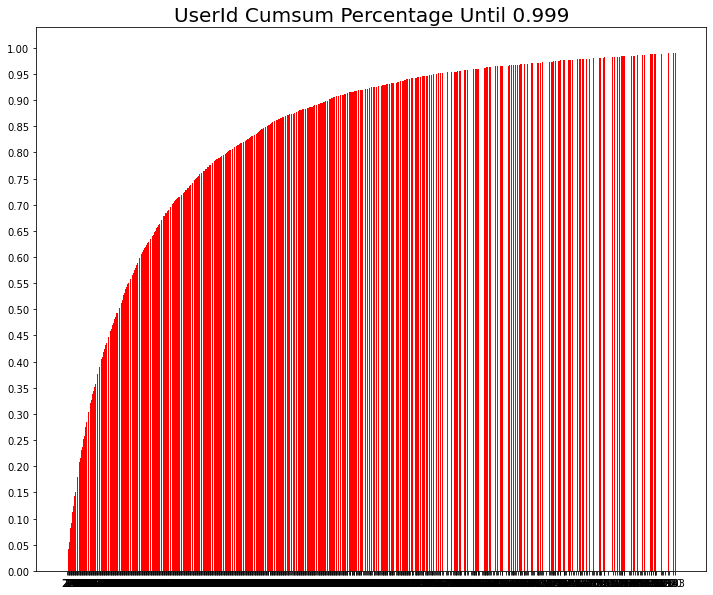

In [11]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('UserId Cumsum Percentage Until 0.999', size=20)
plt.show()

### 1-2. Time 기준 데이터 확인
---

우선 time이 datetime 형식으로 되어있지않아 한눈에 보기 어려우니 형식을 바꿔줍니다.

In [56]:
######## timestamp에서 datetime 변경 #############
def time_change(Time):
    data = pd.to_datetime(time.strftime('%Y-%m-%d %I:%M:%S', time.gmtime(Time)))
    return data
    

In [57]:
data['time']=data['timestamp'].apply(time_change)
data

,user_id,movie_id,ratings,timestamp,time
31,1,3186,4,978300019,2000-12-31 10:00:19
22,1,1270,5,978300055,2000-12-31 10:00:55
27,1,1721,4,978300055,2000-12-31 10:00:55
37,1,1022,5,978300055,2000-12-31 10:00:55
24,1,2340,3,978300103,2000-12-31 10:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 02:40:29
999988,6040,1921,4,997454464,2001-08-10 02:41:04
1000172,6040,1784,3,997454464,2001-08-10 02:41:04
1000167,6040,161,3,997454486,2001-08-10 02:41:26


In [32]:
# del data['timestamp']
# data

,user_id,movie_id,ratings,time
31,1,3186,4,2000-12-31 10:00:19
22,1,1270,5,2000-12-31 10:00:55
27,1,1721,4,2000-12-31 10:00:55
37,1,1022,5,2000-12-31 10:00:55
24,1,2340,3,2000-12-31 10:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 02:40:29
999988,6040,1921,4,2001-08-10 02:41:04
1000172,6040,1784,3,2001-08-10 02:41:04
1000167,6040,161,3,2001-08-10 02:41:26


편안...... 이제 마저 확인해봅니다

In [62]:
oldest, latest = data['time'].min(), data['time'].max()
print(oldest) 
print(latest)

2000-04-25 11:05:32
2003-02-28 12:51:39


2000년부터 2003년까지 약 3년의 데이터를 가지고 있네요! 

### 1-3. 데이터 클리닝
---
이제 목적에 맞게 데이터를 처리해봅시다. 

우선 우린 추천시스템을 할것이기때문에 3점 미만은 제거해줍니다.

In [63]:
######### 3점 미만 제거 ############
data_cleaning = data[data['ratings'] >= 3]

filtered_data_size = len(data_cleaning)
original_data_size = len(data)

print('원본 size : ', original_data_size, '\n3점 미만 제외 size : ', filtered_data_size)
print('제거 data 갯수 : ', (original_data_size - filtered_data_size))
print('남은 데이터의 비율 : {:.2%}'.format((filtered_data_size / original_data_size)))

원본 size :  1000209 
3점 미만 제외 size :  836478
제거 data 갯수 :  163731
남은 데이터의 비율 : 83.63%


163,731개의 비선호 데이터를 지워 83%의 데이터만 남았습니다. 

또 혹시나 같은 사람이 같은 영화에 중복으로 별점을 준 데이터가 있는지도 확인해봅니다.

In [64]:
########## 같은 사람이 중복 별점 확인 ##########
data.duplicated(subset = ['user_id','movie_id']).sum()

0

없네요 다행입니다~:)

그리고 아까 같은 시간에 우다다 누르셨던 분을 다시 소환해서 시간적인 부분에서 제약을 추가해 봐도 좋을 것 같습니다.

In [65]:
########## 이상한 유저 ###########
long_Id = UserId_length[UserId_length >= 2300].index[0]

data_cleaning[data_cleaning['user_id'] == long_Id].head(30)

,user_id,movie_id,ratings,timestamp,time
696969,4169,1268,5,965333392,2000-08-03 08:09:52
697168,4169,2617,4,965333392,2000-08-03 08:09:52
697185,4169,2628,4,965333392,2000-08-03 08:09:52
697219,4169,2653,4,965333392,2000-08-03 08:09:52
697275,4169,423,3,965333392,2000-08-03 08:09:52
696168,4169,3801,5,965333481,2000-08-03 08:11:21
697903,4169,3761,3,965333481,2000-08-03 08:11:21
697954,4169,3788,3,965333481,2000-08-03 08:11:21
695653,4169,3794,4,965333519,2000-08-03 08:11:59
696188,4169,3811,5,965333519,2000-08-03 08:11:59


1초에 최대 8개를 우다다다 누른것은 이상하긴 한데,,, 그렇다고 좋아하지않는다고 할 순 없을 것 같습니다...  어떻게하면 좋을까요?  
우선 이렇게 같은 사람이 같은 시간에 여러개를 체크한게 얼마나 있는지 보겠습니다.

In [66]:
############ 같은 시간에 여러 평점 확인 #############
data_cleaning.duplicated(subset = ['user_id','time']).sum()

413080

In [61]:
data_cleaning[data_cleaning.duplicated(subset = ['user_id','timestamp'])]

,user_id,movie_id,ratings,timestamp
27,1,1721,4,978300055
37,1,1022,5,978300055
47,1,1207,4,978300719
21,1,720,3,978300760
44,1,260,4,978300760
...,...,...,...,...
1000146,6040,2366,3,963272166
1000188,6040,535,4,964828734
1000162,6040,3362,4,997453796
1000069,6040,1258,4,997453909


413,070개로 아까 3점 미안으로 제거한 데이터 갯수보다 약 3~4배정도 많습니다. 
생각보다 이런 경우가 많네요... 

드래그하다 잘못했을 수도있고,, 진짜 클릭이 빠른 사람일 수도 있고,,, 어떤 경우인지는 모르겠으나, 그렇다고 이 사람의 취향을 없애기엔 마음이 찜찜하니 동일시간 다중 체크는 넘어가기로 합니다.(그것도 니 선택이다 이 유저야!)


## STEP 2. 미니배치의 구성
---
Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.   
저는 3년 데이터 모두 사용하고 20% test+val 값을 갖기 위해 220일 기준으로 나누겠습니다.

In [67]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['time'].max()
    session_last_time = data.groupby('user_id')['time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['user_id'].isin(session_in_train)]
    after_date = data[data['user_id'].isin(session_in_test)]
    after_date = after_date[after_date['movie_id'].isin(before_date['movie_id'])]
    return before_date, after_date

In [93]:
tr, test = split_by_date(data_cleaning, n_days=220)
tr, val = split_by_date(tr, n_days=220)

In [94]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["user_id"].nunique()}\n'
          f'\t Items: {data["movie_id"].nunique()}\n'
          f'\t First Time : {data["time"].min()}\n'
          f'\t Last Time : {data["time"].max()}\n')

In [95]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 651658
	 Sessions: 5439
	 Items: 3576
	 First Time : 2000-04-25 11:05:32
	 Last Time : 2001-12-11 12:40:07

* valid Set Stats Info
	 Events: 64812
	 Sessions: 244
	 Items: 3198
	 First Time : 2000-04-27 01:55:48
	 Last Time : 2002-07-22 12:22:19

* test Set Stats Info
	 Events: 119946
	 Sessions: 356
	 Items: 3293
	 First Time : 2000-04-27 04:38:08
	 Last Time : 2003-02-28 12:51:39



In [96]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['movie_id'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['movie_id'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [97]:
data_path = Path('/content/drive/MyDrive/COLAB_data/recommend_movie/') 

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [98]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['user_id'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['user_id'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('user_id').size().cumsum()
        return offsets

In [99]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,user_id,movie_id,ratings,timestamp,time,item_idx
31,1,3186,4,978300019,2000-12-31 10:00:19,0
22,1,1270,5,978300055,2000-12-31 10:00:55,1
27,1,1721,4,978300055,2000-12-31 10:00:55,2
37,1,1022,5,978300055,2000-12-31 10:00:55,3
24,1,2340,3,978300103,2000-12-31 10:01:43,4
36,1,1836,5,978300172,2000-12-31 10:02:52,5
3,1,3408,4,978300275,2000-12-31 10:04:35,6
7,1,2804,5,978300719,2000-12-31 10:11:59,7
47,1,1207,4,978300719,2000-12-31 10:11:59,8
0,1,1193,5,978300760,2000-12-31 10:12:40,9


In [100]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 651263, 651382, 651658], dtype=int32)

In [101]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5436, 5437, 5438])

In [102]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [103]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,user_id,movie_id,ratings,timestamp,time,item_idx
31,1,3186,4,978300019,2000-12-31 10:00:19,0
22,1,1270,5,978300055,2000-12-31 10:00:55,1
27,1,1721,4,978300055,2000-12-31 10:00:55,2
37,1,1022,5,978300055,2000-12-31 10:00:55,3
24,1,2340,3,978300103,2000-12-31 10:01:43,4
36,1,1836,5,978300172,2000-12-31 10:02:52,5
3,1,3408,4,978300275,2000-12-31 10:04:35,6
7,1,2804,5,978300719,2000-12-31 10:11:59,7
47,1,1207,4,978300719,2000-12-31 10:11:59,8
0,1,1193,5,978300760,2000-12-31 10:12:40,9


In [104]:
iter_ex = iter(tr_data_loader)

In [105]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## STEP 3. Modeling
---

In [106]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [108]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [110]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['movie_id'].nunique()
        self.num_sessions = tr['user_id'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [111]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(2048, 1, 3576)]         0         
                                                                 
 GRU (GRU)                   [(2048, 50),              544200    
                              (2048, 50)]                        
                                                                 
 dropout (Dropout)           (2048, 50)                0         
                                                                 
 dense (Dense)               (2048, 3576)              182376    
                                                                 
Total params: 726,576
Trainable params: 726,576
Non-trainable params: 0
_________________________________________________________________


In [115]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['user_id'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['user_id'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [116]:
# 학습 시간이 다소 오래 소요됩니다.
train_model(model, args)

Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]


IndexError: ignored

이제 성능을 검사해봅니다.

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)